## Imports
Warning about the drive adress, to be change for an other drive

In [ ]:
import argparse
from glob import glob
import os

import numpy as np
import torch
import matplotlib.pyplot as plt
import tqdm as tqdm

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
#chemin pour le drive de Marien -> à changer pour Emeric
%cd /content/drive/MyDrive/Colab_Notebooks/Projet_Remote_Sensing
# %cd /content/drive/MyDrive/Projet_Remote_Sensing/

[Errno 2] No such file or directory: 'rootdir'
/content/drive/MyDrive/Colab_Notebooks/Projet_Remote_Sensing


In [ ]:
from Dataset import *
from model import *
from utils import *
#to be change for Emeric
# rootdir = '/content/drive/MyDrive/Projet_Remote_Sensing/'
rootdir = '/content/drive/MyDrive/Colab_Notebooks/Projet_Remote_Sensing/'
basedir = rootdir + 'SAR-CNN-U-Net_with_test'
datasetdir = rootdir + 'PRAT/data'

In [ ]:
checkpoint = torch.load('model.pth')

In [ ]:
#the .pth contain all the weight of the model
checkpoint.keys()

odict_keys(['enc0.weight', 'enc0.bias', 'enc1.weight', 'enc1.bias', 'enc2.weight', 'enc2.bias', 'enc3.weight', 'enc3.bias', 'enc4.weight', 'enc4.bias', 'enc5.weight', 'enc5.bias', 'enc6.weight', 'enc6.bias', 'dec5.weight', 'dec5.bias', 'dec5b.weight', 'dec5b.bias', 'dec4.weight', 'dec4.bias', 'dec4b.weight', 'dec4b.bias', 'dec3.weight', 'dec3.bias', 'dec3b.weight', 'dec3b.bias', 'dec2.weight', 'dec2.bias', 'dec2b.weight', 'dec2b.bias', 'dec1a.weight', 'dec1a.bias', 'dec1b.weight', 'dec1b.bias', 'dec1.weight', 'dec1.bias'])

In [ ]:
#parameters of the model
batch_size = 12
val_batch_size = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = AE(batch_size,val_batch_size,device)
#put the learning weights on the model
model.load_state_dict(checkpoint)

<All keys matched successfully>

# Test of the model

In [ ]:
def threshold(im, name):
  """
  A function to make a good threshold for the different type of images
  """
  choices = {'marais1':190.92, 'marais2': 168.49, 'saclay':470.92, 'lely':235.90, 'ramb':167.22, 'risoul':306.94, 'limagne':178.43}
  threshold = 0
  for x in choices:
    if name == x:
        threshold = choices.get(x)
  if threshold ==0:
    threshold= np.mean(im)+3*np.std(im) 

  dim = np.clip(im,0,threshold)
  dim = dim/threshold*255
  return dim

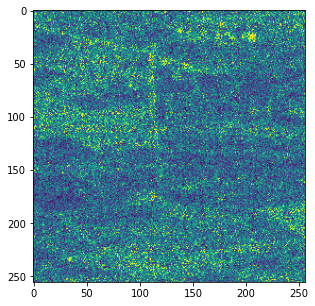

In [ ]:
#an example or a noisy image of the test set
im = np.load('PRAT/data/test/noisy/marais2_10_0.npy')
im = threshold(im, 'marais1')

plt.figure(figsize=(5,5))
plt.imshow(im)
plt.show()

In [ ]:
M = 10.089038980848645
m = -1.429329123112601

def normalized_SAR(im, M = 10.089038980848645, m = -1.429329123112601):
  """
  A function to normalized the SAR image. Return in the log domain between 0 and 1. 
  M is the max in the log domain, m the min.
  """
  return (torch.log(im+1e-6)-m)/(M-m)

def inverse_normalized_SAR(im, M = 10.089038980848645, m = -1.429329123112601):
  """
  A function to inverse the normalization the SAR image. From a log-domain image between 0 and 1 
  return in the natural domain with the good amplitude. 
  """
  return torch.exp((M-m)*im+m) - 1e-6

In [ ]:
def denoiser_256(im, model):
  """
  Take one numpy image of size 256*256 an apply the NN SAR denoiser to it. Return a numpy image desnoised of size 256*256
  """
  im = torch.tensor(im)
  im_log = normalized_SAR(im)
  im_log = im_log[None,:,:,None]
  im_denoised_log = model.forward(im_log, batch_size = 1)[0,0,:,:]
  im_denoised = inverse_normalized_SAR(im_denoised_log)
  return im_denoised.detach().numpy()

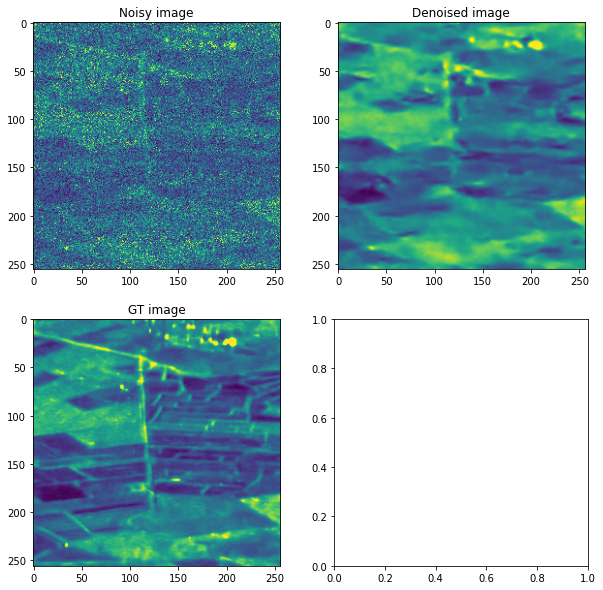

In [ ]:
im = np.load('PRAT/data/test/noisy/marais2_10_0.npy')
im = threshold(im, '')
im_denoised = denoiser_256(im, model)
im_denoised = threshold(im_denoised, '')
im_gt = np.load('PRAT/data/test/groundtruth/marais2_10_0.npy')
im_gt = threshold(im_gt, '')

fig, axs = plt.subplots(2, 2, figsize = (10,10))
axs[0,0].imshow(im)
axs[0,0].set_title('Noisy image')
axs[0,1].imshow(im_denoised)
axs[0,1].set_title('Denoised image')
axs[1,0].imshow(im_gt)
axs[1,0].set_title('GT image')

plt.show()

Text(0.5, 1.0, 'GT image')

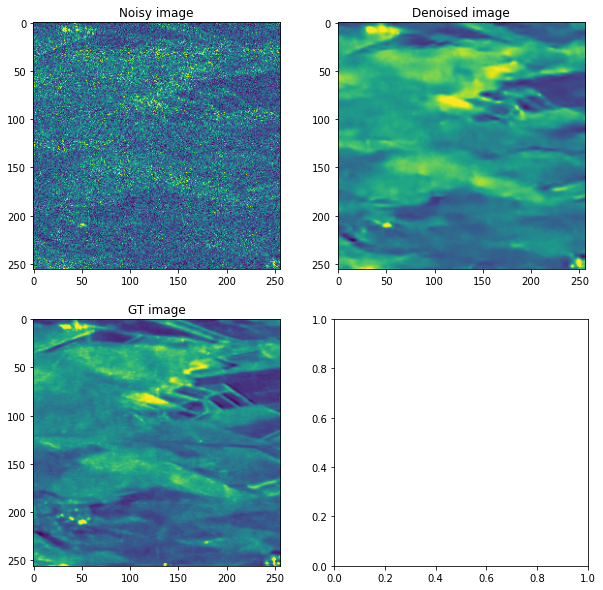

In [ ]:
im = np.load('PRAT/data/test/noisy/marais2_10_1.npy')
im = threshold(im, '')
im_denoised = denoiser_256(im, model)
im_denoised = threshold(im_denoised, '')
im_gt = np.load('PRAT/data/test/groundtruth/marais2_10_1.npy')
im_gt = threshold(im_gt, '')

fig, axs = plt.subplots(2, 2, figsize = (10,10))
axs[0,0].imshow(im)
axs[0,0].set_title('Noisy image')
axs[0,1].imshow(im_denoised)
axs[0,1].set_title('Denoised image')
axs[1,0].imshow(im_gt)
axs[1,0].set_title('GT image')

# Test avec la méthode du papier
On commence par prendre les images de ratio, on les débruite (après avoir ramené la distribution proche de celle des images SAR) puis on les débruite et on reconstruit l'image initiale.

## Create dataset

In [ ]:
def generate_speckle(x,L):
  """
  Add speckle to a log-normalized image (torch.tensor)
  """
  s = torch.zeros(x.size())
  for k in range(L):
      gamma = (torch.abs(torch.complex(torch.normal(0,1,x.size()),torch.normal(0,1,x.size()))) ** 2)/2
      s = s+gamma
  s_amplitude = torch.sqrt(s/L)
  s_log = torch.log(s_amplitude)
  log_norm_s = s_log / (M-m)
  return x + log_norm_s

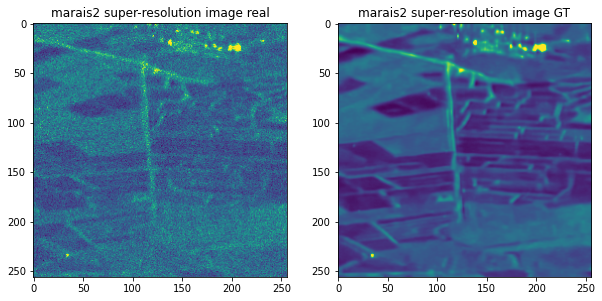

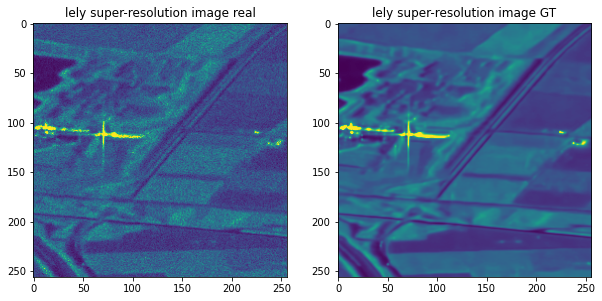

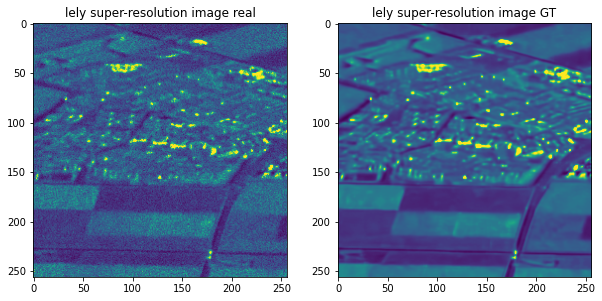

In [ ]:
#Computation of ratio image with speckle and plot of the mean image -> super-resolution image
list_im = ['marais2', 'lely', 'lely']# 'limagne'}
im_location = np.array([[0,0],[0,0],[500,2150]])

super_resolution_list = []
super_resolution_gt_list = []
Im_gt_list = []
Im_ratio_list = []
Im_ratio_gt_list = []
Im_noisy_list = []

i_begin = 21
i_end = 31

for k, short_name in enumerate(list_im):
  Im_ratio = []
  Im_noisy = []
  Im_gt = []

  for i in range(i_begin,i_end):
    #very important to do it on additional data otherwise we use the model on his train data
    name = rootdir + 'PRAT/data/additional_data/'+short_name+'_'+str(i)+'.npy'
    im = np.load(name)
    im = im[im_location[k,0]:im_location[k,0]+256,im_location[k,1]:im_location[k,1]+256]
    Im_ratio.append(im)
    Im_noisy.append(im)
    Im_gt.append(im)

  Im_ratio = torch.tensor(Im_ratio)
  Im_noisy = torch.tensor(Im_noisy)
  Im_gt = np.array(Im_gt)

  #add speckle to each image (independant for each one)
  for i in range(i_end - i_begin):
    Im_ratio[i] = inverse_normalized_SAR(generate_speckle(normalized_SAR(Im_ratio[i]),L=1))#L= 1, one observation for each image
    Im_noisy[i] = Im_ratio[i]

  super_resolution = torch.mean(Im_ratio, axis=0)
  super_resolution_gt = np.mean(Im_gt, axis=0)

  #plot the super-resolue image
  super_resolution_thresh = threshold(super_resolution.detach().numpy(), short_name)
  super_resolution_gt_thresh = threshold(super_resolution_gt, short_name)

  plt.figure(figsize=(10,10))
  
  plt.subplot(121)
  plt.imshow(super_resolution_thresh)
  plt.title(short_name+' super-resolution image real')
  plt.subplot(122)
  plt.imshow(super_resolution_gt_thresh)
  plt.title(short_name+' super-resolution image GT')
  plt.show()

  Im_ratio_gt = Im_ratio / super_resolution_gt[None,:,:]
  Im_ratio = Im_ratio / super_resolution[None,:,:]

  super_resolution_list.append(super_resolution)
  super_resolution_gt_list.append(super_resolution_gt)
  Im_gt_list.append(Im_gt)
  Im_ratio_list.append(Im_ratio)
  Im_ratio_gt_list.append(Im_ratio_gt)
  Im_noisy_list.append(Im_noisy)

## Test with a local normalization (for each pixel)
It's a bad normalization because we normalised on temporal axis not on spatial one.

---



In [ ]:
i = 0

super_resolution = super_resolution_list[i]
super_resolution_gt = super_resolution_gt_list[i]
Im_gt = Im_gt_list[i]
Im_ratio = Im_ratio_list[i]
Im_ratio_gt = Im_ratio_gt_list[i]
Im_noisy = Im_noisy_list[i]

In [ ]:
#we out the same mean and variance for pixel in the ratio image than in the SAR image (in the log-domain)
Im_noisy_log = torch.log(Im_noisy + 1e-6)
mean_tr = torch.mean(Im_noisy_log, axis = 0)
std_tr = torch.std(Im_noisy_log, axis = 0)

Im_ratio_log = torch.log(Im_ratio + 1e-6)
mean_ratio = torch.mean(Im_ratio_log, axis = 0)
std_ratio = torch.std(Im_ratio_log, axis = 0)

Im_ratio_log_norm = (Im_ratio_log - mean_ratio) / (std_ratio + 1e-10)
Im_ratio_log_norm = std_tr * Im_ratio_log_norm + mean_tr

#return in the standard domain
Im_ratio_norm = torch.exp(Im_ratio_log_norm) - 1e-6

In [ ]:
#check if the distribution have the same mean and std
print(torch.sum(torch.abs(torch.std(Im_noisy_log, axis = 0) - torch.std(Im_ratio_log_norm, axis = 0))))
print(torch.sum(torch.abs(torch.mean(Im_noisy_log, axis = 0) - torch.mean(Im_ratio_log_norm, axis = 0))))

tensor(6.5536e-06, dtype=torch.float64)
tensor(1.4083e-11, dtype=torch.float64)


In [ ]:
ims = normalized_SAR(Im_ratio_norm[:,:,:,None].to(torch.float32))
y = model.forward(ims, batch_size = 11)
print(y.size())
y = inverse_normalized_SAR(y)

torch.Size([10, 1, 256, 256])


In [ ]:
# put the right mean and std on y_log
y_log = torch.log(y + 1e-6)
y_log = std_ratio[:256,:256] * ((y_log - mean_tr[:256,:256]) / (std_tr[:256,:256] + 1e-10)) + mean_ratio[:256,:256]
y = torch.exp(y_log) - 1e-6

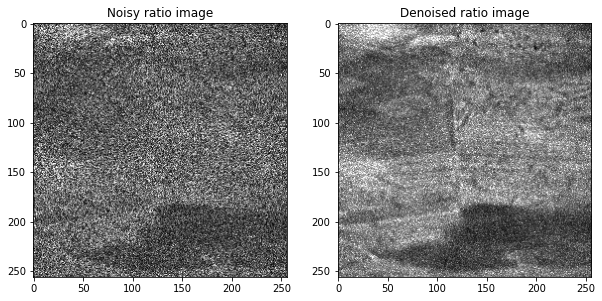

In [ ]:
#different between the ratio images
im_ratio_th = threshold(Im_ratio[0,:256,:256].detach().numpy(), '')
im_denoised_ratio_th = threshold(y[0,0,:,:].detach().numpy(), '')

fig, axs = plt.subplots(1, 2, figsize = (10,10))
axs[0].imshow(im_ratio_th, cmap='gray')
axs[0].set_title('Noisy ratio image')
axs[1].imshow(im_denoised_ratio_th, cmap='gray')
axs[1].set_title('Denoised ratio image')
plt.show()

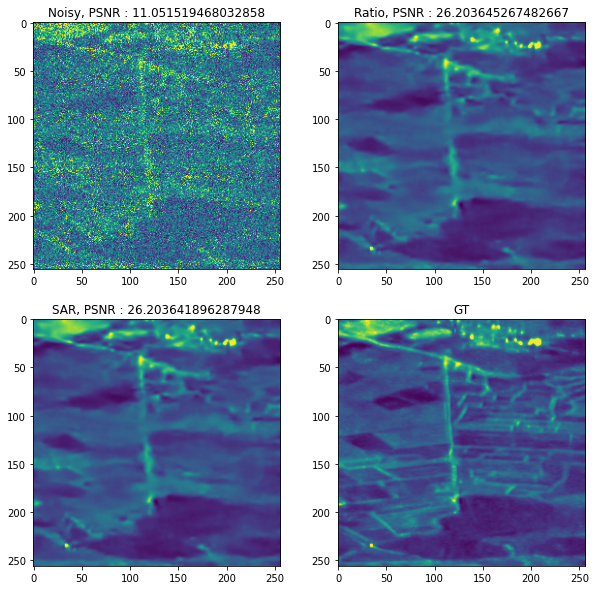

In [ ]:
im_noisy = Im_noisy[0,:256,:256].detach().numpy()
im_ratio = (y[0,0,:,:] * super_resolution[:256,:256]).detach().numpy()
im_sar = denoiser_256(Im_noisy[0,:256,:256].to(torch.float32).detach().numpy(), model)
im_gt = Im_gt[0,:256,:256]

name = 'marais2'

im_noisy_th = threshold(im_noisy, name)
psnr_noisy = cal_psnr(im_noisy, im_gt)

im_ratio_th = threshold(im_ratio, name)
psnr_ratio = cal_psnr(im_ratio, im_gt)

im_sar_th = threshold(im_sar, name)
psnr_sar = cal_psnr(im_sar, im_gt)

im_gt_th = threshold(im_gt, name)

fig, axs = plt.subplots(2, 2, figsize = (10,10))


axs[0,0].imshow(im_noisy_th)
axs[0,0].set_title('Noisy, PSNR : '+str(psnr_noisy))
axs[0,1].imshow(im_ratio_th)
axs[0,1].set_title('Ratio, PSNR : '+str(psnr_ratio))
axs[1,0].imshow(im_sar_th)
axs[1,0].set_title('SAR, PSNR : '+str(psnr_sar))
axs[1,1].imshow(im_gt_th)
axs[1,1].set_title('GT')

plt.show()

<ipython-input-75-3dfb9ef68887>:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(im_ratio_th - im_sar_th)))


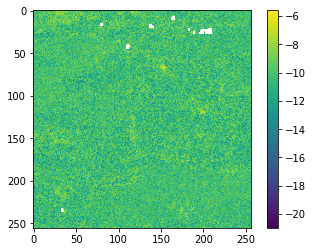

In [ ]:
plt.imshow(np.log(np.abs(im_ratio_th - im_sar_th)))
plt.colorbar()

In [ ]:
PSNR_noisy = []
PSNR_ratio = []
PSNR_sar = []

for i in range(i_end-i_begin):
  im_noisy = Im_noisy[i,:256,:256].detach().numpy()
  im_ratio = (y[i,0,:,:] * super_resolution[:256,:256]).detach().numpy()
  im_sar = denoiser_256(Im_noisy[i,:256,:256].to(torch.float32).detach().numpy(), model)
  im_gt = Im_gt[i,:256,:256]
  # calculate PSNR
  psnr_noisy = cal_psnr(im_noisy, im_gt)
  PSNR_noisy.append(psnr_noisy)
  psnr_ratio = cal_psnr(im_ratio, im_gt)
  PSNR_ratio.append(psnr_ratio)
  psnr_sar = cal_psnr(im_sar, im_gt)
  PSNR_sar.append(psnr_sar)

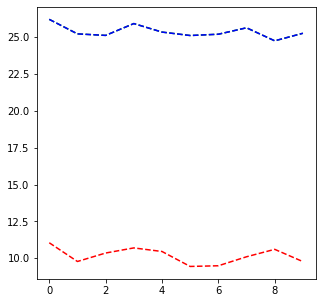

In [ ]:
#Two PSNR are superpose
plt.figure(figsize=(5,5))
plt.plot(PSNR_noisy, 'r--')
plt.plot(PSNR_ratio, 'g--')
plt.plot(PSNR_sar, 'b--')
plt.show()

## With a normalization not in pixels but in the whole distribution

In [ ]:
#we out the same mean and variance for pixel in the ratio image than in the SAR image (in the log-domain)
Im_noisy_log = torch.log(Im_noisy + 1e-6)
mean_tr = torch.mean(Im_noisy_log)
std_tr = torch.std(Im_noisy_log)

Im_ratio_log = torch.log(Im_ratio + 1e-6)
mean_ratio = torch.mean(Im_ratio_log)
std_ratio = torch.std(Im_ratio_log)

Im_ratio_log_norm = (Im_ratio_log - mean_ratio) / (std_ratio + 1e-10)
Im_ratio_log_norm = std_tr * Im_ratio_log_norm + mean_tr

#return in the standard domain
Im_ratio_norm = torch.exp(Im_ratio_log_norm) - 1e-6

In [ ]:
#check if the distribution have the same mean and std
print(torch.sum(torch.abs(torch.std(Im_noisy_log) - torch.std(Im_ratio_log_norm))))
print(torch.sum(torch.abs(torch.mean(Im_noisy_log) - torch.mean(Im_ratio_log_norm))))

tensor(1.0968e-10, dtype=torch.float64)
tensor(8.8818e-16, dtype=torch.float64)


In [ ]:
#take a window of 256*256
ims = normalized_SAR(Im_ratio_norm[:,:256,:256,None].to(torch.float32))
y = model.forward(ims, batch_size = 11)
print(y.size())
y = inverse_normalized_SAR(y)

# put the right mean and std on y_log
y_log = torch.log(y + 1e-6)
y_log = std_ratio * ((y_log - mean_tr) / (std_tr + 1e-10)) + mean_ratio
y = torch.exp(y_log) - 1e-6

torch.Size([11, 1, 256, 256])


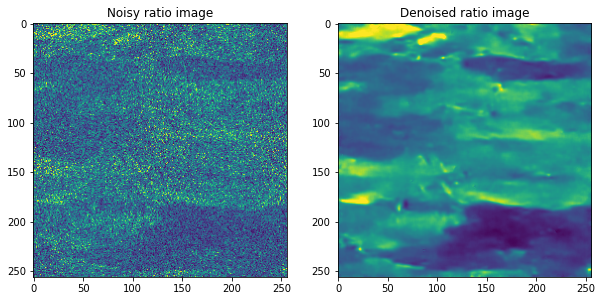

In [ ]:
#different between the ratio images
im_ratio_th = threshold(Im_ratio[0,:256,:256].detach().numpy(), '')
im_denoised_ratio_th = threshold(y[0,0,:,:].detach().numpy(), '')

fig, axs = plt.subplots(1, 2, figsize = (10,10))
axs[0].imshow(im_ratio_th)
axs[0].set_title('Noisy ratio image')
axs[1].imshow(im_denoised_ratio_th)
axs[1].set_title('Denoised ratio image')
plt.show()

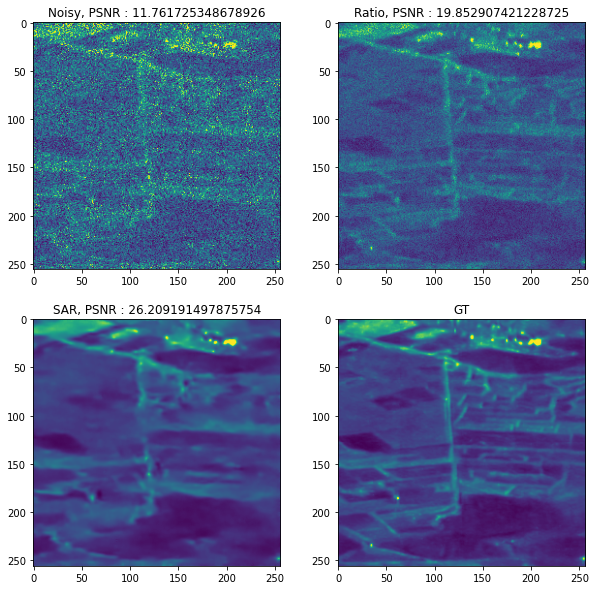

In [ ]:
im_noisy = Im_noisy[0,:256,:256].detach().numpy()
im_ratio = (y[0,0,:,:] * super_resolution[:256,:256]).detach().numpy()
im_sar = denoiser_256(Im_noisy[0,:256,:256].to(torch.float32).detach().numpy())
im_gt = Im_gt[0,:256,:256]

name = 'marais1'

im_noisy_th = threshold(im_noisy, name)
psnr_noisy = cal_psnr(im_noisy, im_gt)

im_ratio_th = threshold(im_ratio, name)
psnr_ratio = cal_psnr(im_ratio, im_gt)

im_sar_th = threshold(im_sar, name)
psnr_sar = cal_psnr(im_sar, im_gt)

im_gt_th = threshold(im_gt, name)

fig, axs = plt.subplots(2, 2, figsize = (10,10))


axs[0,0].imshow(im_noisy_th)
axs[0,0].set_title('Noisy, PSNR : '+str(psnr_noisy))
axs[0,1].imshow(im_ratio_th)
axs[0,1].set_title('Ratio, PSNR : '+str(psnr_ratio))
axs[1,0].imshow(im_sar_th)
axs[1,0].set_title('SAR, PSNR : '+str(psnr_sar))
axs[1,1].imshow(im_gt_th)
axs[1,1].set_title('GT')

plt.show()

In [ ]:
for i in range(11):
  im_noisy = Im_noisy[i,:256,:256].detach().numpy()
  im_ratio = (y[i,0,:,:] * super_resolution[:256,:256]).detach().numpy()
  im_sar = denoiser_256(Im_noisy[i,:256,:256].to(torch.float32).detach().numpy())
  im_gt = Im_gt[i,:256,:256]
  print("For the image ",i)
  # calculate PSNR
  psnr = cal_psnr(im_noisy, im_gt)
  print("PSNR noisy: ",psnr)
  psnr = cal_psnr(im_ratio, im_gt)
  print("PSNR ratio: ",psnr)
  psnr = cal_psnr(im_sar, im_gt)
  print("PSNR sar: ",psnr)

For the image  0
PSNR noisy:  11.761725348678926
PSNR ratio:  19.852907421228725
PSNR sar:  26.209191497875754
For the image  1
PSNR noisy:  11.004937420992684
PSNR ratio:  19.201614645094736
PSNR sar:  26.01292380394348
For the image  2
PSNR noisy:  9.773978996446166
PSNR ratio:  18.0671102487735
PSNR sar:  25.237115520285506
For the image  3
PSNR noisy:  10.374877159339455
PSNR ratio:  18.472829097786715
PSNR sar:  25.397409527617217
For the image  4
PSNR noisy:  10.63892405337032
PSNR ratio:  18.80356612719876
PSNR sar:  25.041506479378945
For the image  5
PSNR noisy:  10.401715201661403
PSNR ratio:  18.626819298494194
PSNR sar:  24.732814881071405
For the image  6
PSNR noisy:  9.444803466421185
PSNR ratio:  17.820108562960296
PSNR sar:  25.41413990423084
For the image  7
PSNR noisy:  9.50965354540285
PSNR ratio:  17.691190660255735
PSNR sar:  24.79717692656465
For the image  8
PSNR noisy:  10.101812151497045
PSNR ratio:  18.35574941536674
PSNR sar:  25.2725169083195
For the image  

## A denoising of a general image
To denoise not just 256*256 images

In [ ]:
def general_denoised(ims):
  """
  Apply the denoiser model to the set of image ims (of size bigger than 256*256).
  """
  #le noyau plante -> calcul trop lourd pour colab

  ims = normalized_SAR(Im_ratio_norm[:,:,:,None].to(torch.float32))
  print(ims.size())
  p, n, m, _ = ims.size()
  ims_denoised = torch.zeros(ims.size())
  for i in tqdm(range(n // 256)):
    for j in range(m // 256):
      ims_denoised[:,i*256:(i+1)*256,j*256:(j+1)*256,:] = torch.permute(model.forward(ims[:,i*256:(i+1)*256,j*256:(j+1)*256,:], batch_size = p), (0,2,3,1)) 
      
  for i in range(n // 256):
    ims_denoised[:,i*256:(i+1)*256,-m % 256:,:] = torch.permute(model.forward(ims[:,i*256:(i+1)*256,-256:,:], batch_size = p), (0,2,3,1))[:,:,-m % 256:,:]

  for j in range(m // 256):
    ims_denoised[:,-n % 256:,j*256:(j+1)*256,:] = torch.permute(model.forward(ims[:,-256:,j*256:(j+1)*256,:], batch_size = p), (0,2,3,1))[:,:,-n % 256:,:]

  print(ims_denoised.size())
  ims_denoised = inverse_normalized_SAR(ims_denoised)
  return ims_denoised

## Denoise with gt ratio

In [ ]:
# Import ratio model
checkpoint = torch.load('model_ratio.pth')

#parameters of the model
batch_size = 12
val_batch_size = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ratio = AE(batch_size,val_batch_size,device)

#put the learning weights on the model
model_ratio.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
name = 'marais1'
idx = 0

# Choose an image
im_noisy = Im_noisy[idx, :256, :256].detach().numpy().astype(np.float32)

# Get ground-truth 
im_gt = Im_gt[idx, :256, :256]

# Create ratio image with normalized super-image
super_image_gt = np.mean(Im_gt, axis=0)[:256, :256].astype(np.float32)
super_image_gt_log = np.log(super_image_gt + 1e-6)
lbda = np.exp(np.mean(super_image_gt_log))
super_image_gt_norm = super_image_gt / lbda

im_ratio_norm = im_noisy / super_image_gt_norm

# Create classical ratio image 
im_ratio = im_noisy / super_image_gt

# Denoising
im_sar = denoiser_256(im_noisy, model)
im_sar_with_ratio = denoiser_256(im_ratio_norm, model) *  super_image_gt_norm
im_ratiosar =  denoiser_256(im_ratio, model_ratio) * super_image_gt

In [ ]:
# Get thresholded images
im_noisy_th = threshold(im_noisy, name)
im_sar_with_ratio_th = threshold(im_sar_with_ratio, name)
im_ratiosar_th = threshold(im_ratiosar, name)
im_sar_th = threshold(im_sar, name)
im_gt_th = threshold(im_gt, name)

# Compute PSNR
psnr_noisy = cal_psnr(im_noisy, im_gt)
psnr_sar_with_ratio = cal_psnr(im_sar_with_ratio, im_gt)
psnr_ratiosar = cal_psnr(im_ratiosar, im_gt)
psnr_sar = cal_psnr(im_sar, im_gt)

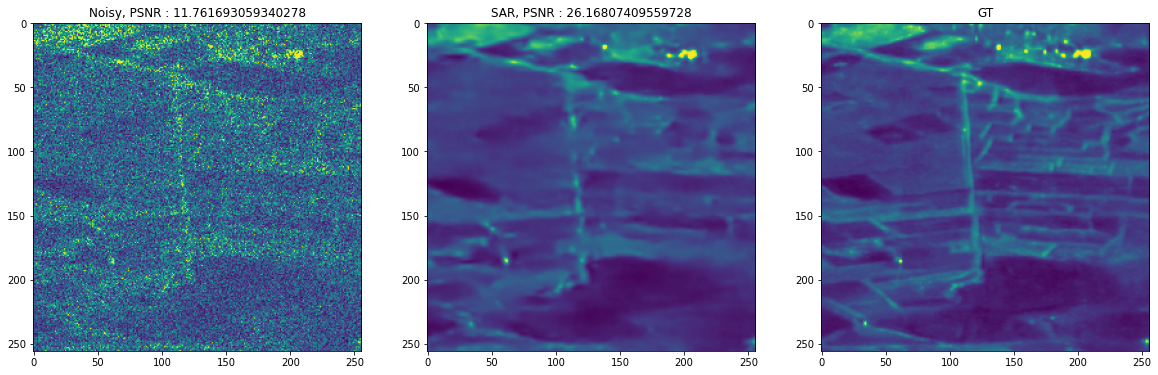

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20,10))

axs[0].imshow(im_noisy_th)
axs[0].set_title('Noisy, PSNR : '+str(psnr_noisy))

axs[1].imshow(im_sar_th)
axs[1].set_title('SAR, PSNR : '+str(psnr_sar))

axs[2].imshow(im_gt_th)
axs[2].set_title('GT')
plt.show()

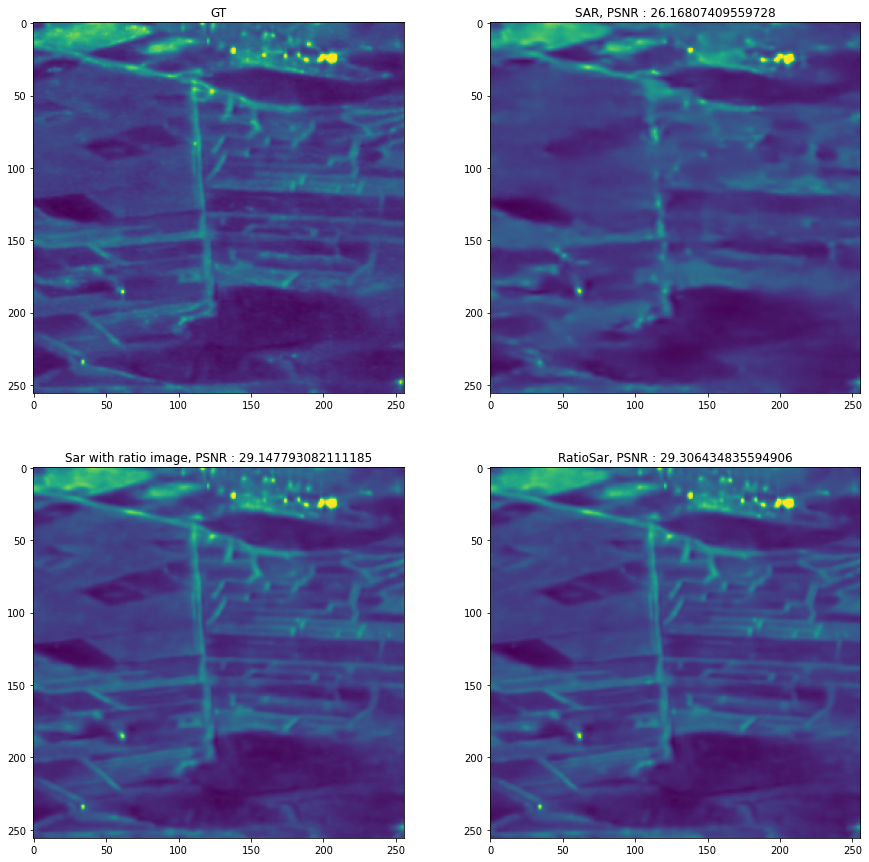

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (15,15))

axs[0,0].imshow(im_gt_th)
axs[0,0].set_title('GT')

axs[0,1].imshow(im_sar_th)
axs[0,1].set_title('SAR, PSNR : '+str(psnr_sar))

axs[1,0].imshow(im_sar_with_ratio_th)
axs[1,0].set_title('Sar with ratio image, PSNR : '+str(psnr_sar_with_ratio))

axs[1,1].imshow(im_ratiosar_th)
axs[1,1].set_title('RatioSar, PSNR : '+str(psnr_ratiosar))

plt.show()

In [ ]:
# Now if the super image is made from noisy images

# Create ratio image with normalized super-image
super_image_noisy = np.mean(Im_noisy.numpy(), axis=0)[:256, :256].astype(np.float32)
super_image_noisy_log = np.log(super_image_noisy + 1e-6)
lbda_noisy = np.exp(np.mean(super_image_noisy_log))
super_image_noisy_norm = super_image_noisy / lbda_noisy

im_ratio_noisy_norm = im_noisy / super_image_noisy_norm

# Create classical ratio image 
im_ratio_noisy = im_noisy / super_image_noisy

# Denoising
im_sar_with_ratio_noisy = denoiser_256(im_ratio_noisy_norm, model) *  super_image_noisy_norm
im_ratiosar_noisy =  denoiser_256(im_ratio_noisy, model_ratio) * super_image_noisy

In [ ]:
# Get thresholded images
im_sar_with_ratio_noisy_th = threshold(im_sar_with_ratio_noisy, name)
im_ratiosar_noisy_th = threshold(im_ratiosar_noisy, name)
super_image_noisy_th = threshold(super_image_noisy, name)

# Compute PSNR
psnr_sar_with_ratio_noisy = cal_psnr(im_sar_with_ratio_noisy, im_gt)
psnr_ratiosar_noisy = cal_psnr(im_ratiosar_noisy, im_gt)
psnr_super_image_noisy = cal_psnr(super_image_noisy, im_gt)

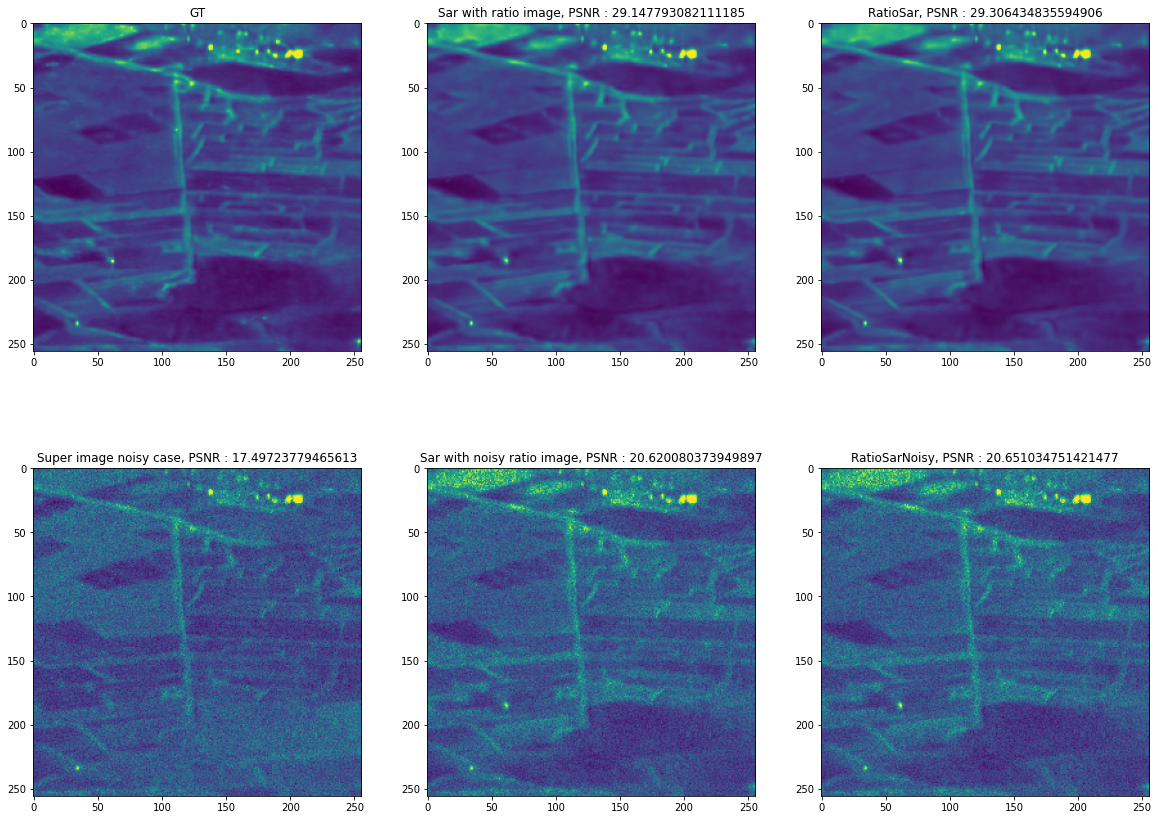

In [ ]:
fig, axs = plt.subplots(2, 3, figsize = (20,15))

axs[0,0].imshow(im_gt_th)
axs[0,0].set_title('GT')

axs[0,1].imshow(im_sar_with_ratio_th)
axs[0,1].set_title(f'Sar with ratio image, PSNR : {psnr_sar_with_ratio}')

axs[0,2].imshow(im_ratiosar_th)
axs[0,2].set_title(f'RatioSar, PSNR : {psnr_ratiosar}')

axs[1,0].imshow(super_image_noisy_th)
axs[1,0].set_title(f'Super image noisy case, PSNR : {psnr_super_image_noisy}')

axs[1,1].imshow(im_sar_with_ratio_noisy_th)
axs[1,1].set_title(f'Sar with noisy ratio image, PSNR : {psnr_sar_with_ratio_noisy}')

axs[1,2].imshow(im_ratiosar_noisy_th)
axs[1,2].set_title(f'RatioSarNoisy, PSNR : {psnr_ratiosar_noisy}')

plt.show()

In [ ]:
psnr = np.zeros((11, 3))

for i in range(11):
  im_noisy = Im_noisy[i, :256, :256].detach().numpy()

  im_ratio = Im_noisy[i, :256, :256].detach().numpy() / super_image_gt[:256, :256]
  im_ratio =  denoiser_256(im_ratio.astype(np.float32), model_ratio) * super_image_gt[:256, :256]

  im_ratio_norm = Im_noisy[i,:256,:256] / super_image_gt_norm
  im_sar = denoiser_256(im_ratio_norm.to(torch.float32).detach().numpy(), model)
  im_sar *= super_image_gt_norm

  im_gt = Im_gt[i,:256,:256]

  # calculate PSNR
  psnr[i, 0] = cal_psnr(im_noisy, im_gt).astype(np.float32)
  psnr[i, 1] = cal_psnr(im_sar, im_gt).astype(np.float32)
  psnr[i, 2] = cal_psnr(im_ratio, im_gt).astype(np.float32)

  print("For the image ",i)
  print("PSNR noisy: ",psnr[i, 0])
  print("PSNR sar: ",psnr[i, 1])
  print("PSNR ratio: ",psnr[i, 2])
  print('')

For the image  0
PSNR noisy:  11.761693000793457
PSNR sar:  29.147794723510742
PSNR ratio:  29.306434631347656

For the image  1
PSNR noisy:  11.058647155761719
PSNR sar:  29.802879333496094
PSNR ratio:  30.261516571044922

For the image  2
PSNR noisy:  9.826933860778809
PSNR sar:  29.39094352722168
PSNR ratio:  29.94047737121582

For the image  3
PSNR noisy:  10.375182151794434
PSNR sar:  28.142131805419922
PSNR ratio:  28.212482452392578

For the image  4
PSNR noisy:  10.67101764678955
PSNR sar:  29.007280349731445
PSNR ratio:  29.19912338256836

For the image  5
PSNR noisy:  10.42984676361084
PSNR sar:  28.80200958251953
PSNR ratio:  28.87789535522461

For the image  6
PSNR noisy:  9.458796501159668
PSNR sar:  29.72372817993164
PSNR ratio:  30.13680076599121

For the image  7
PSNR noisy:  9.512974739074707
PSNR sar:  29.34079360961914
PSNR ratio:  29.760562896728516

For the image  8
PSNR noisy:  10.099017143249512
PSNR sar:  29.023433685302734
PSNR ratio:  29.23501968383789

For th

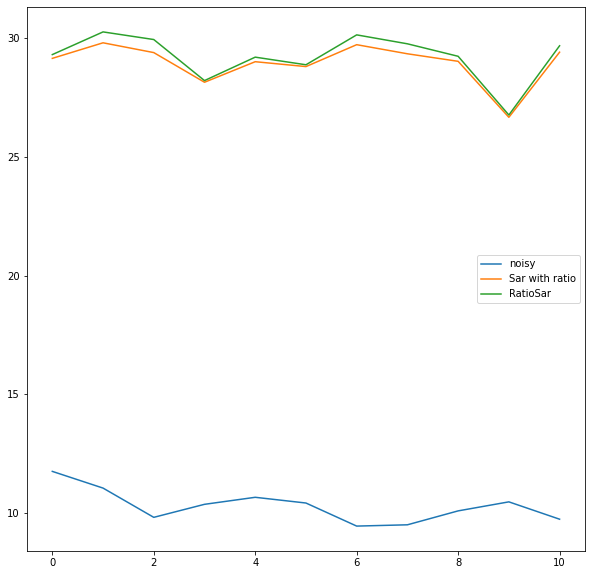

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(psnr[:, 0], label='noisy')
plt.plot(psnr[:, 1], label='Sar with ratio')
plt.plot(psnr[:, 2], label='RatioSar')
plt.legend(loc='best')
plt.show()

## Comparison between ratio images distributions and Natural SAR image distribution
Not a good normalization.
We look at the difference of the distribution in the log domain, to justify if the change of mean and variance is enough.

In [ ]:
print(Im_ratio.size())
print(Im_gt.shape)
print(Im_ratio_norm.size())

torch.Size([11, 1024, 8192])
(11, 1024, 8192)
torch.Size([11, 1024, 8192])


Original distributions :

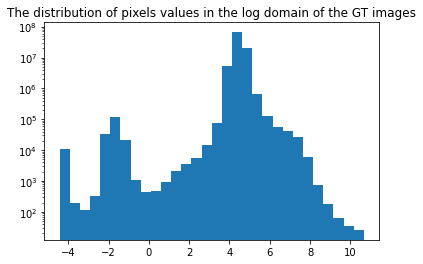

In [ ]:
Im_gt_dist = np.log(Im_gt).reshape(-1)
plt.hist(Im_gt_dist, bins = 30)
plt.yscale('log')
plt.title('The distribution of pixels values in the log domain of the GT images')
plt.show()

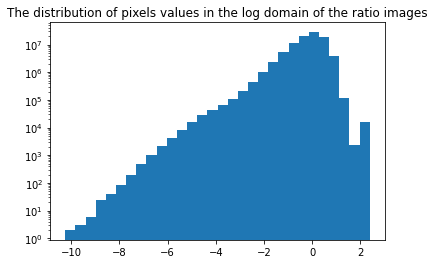

In [ ]:
Im_ratio_dist = torch.log(Im_ratio).detach().numpy().reshape(-1)
plt.hist(Im_ratio_dist, bins = 30)
plt.yscale('log')
plt.title('The distribution of pixels values in the log domain of the ratio images')
plt.show()

After the re-normalization

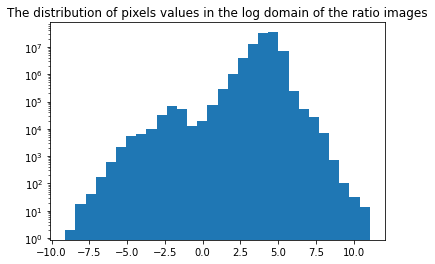

In [ ]:
Im_ratio_norm_dist = torch.log(Im_ratio_norm).detach().numpy().reshape(-1)
plt.hist(Im_ratio_norm_dist, bins = 30)
plt.yscale('log')
plt.title('The distribution of pixels values in the log domain of the ratio images')
plt.show()

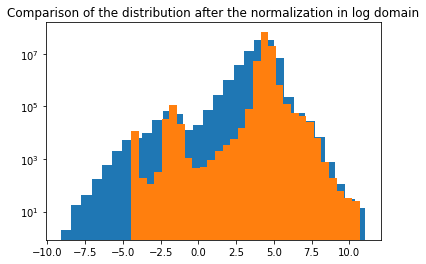

In [ ]:
plt.hist(Im_ratio_norm_dist, bins = 30)
plt.yscale('log')
plt.hist(Im_gt_dist, bins = 30)
plt.title('Comparison of the distribution after the normalization in log domain')
plt.show()

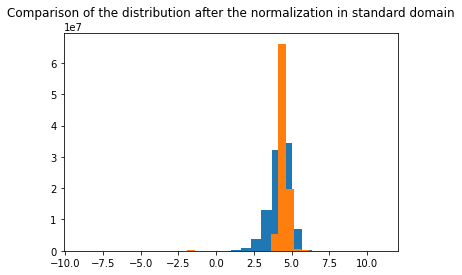

In [ ]:
plt.hist(Im_ratio_norm_dist, bins = 30)
plt.hist(Im_gt_dist, bins = 30)
plt.title('Comparison of the distribution after the normalization in standard domain')
plt.show()

In [ ]:
print(np.mean(Im_ratio_norm_dist))
print(np.mean(Im_gt_dist))
print(np.std(Im_ratio_norm_dist))
print(np.std(Im_gt_dist))

4.170369418602752
4.459010719203446
